# Test IOU

Script per fare test sull'implementazione dell'IOU, in particolare per vedere che risultati ottengo su due masse problematiche.

In [5]:
import os
import argparse
from datetime import datetime
import glob
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image

In [7]:
%matplotlib inline

In [2]:
iou_threshold = 0.2

In [3]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
  # convert the coordinates to the top-left and bottom-right corners
  x1_1 = x1 - w1 / 2
  y1_1 = y1 - h1 / 2
  x1_2 = x1 + w1 / 2
  y1_2 = y1 + h1 / 2
  x2_1 = x2 - w2 / 2
  y2_1 = y2 - h2 / 2
  x2_2 = x2 + w2 / 2
  y2_2 = y2 + h2 / 2

  # compute the area of the bounding boxes
  area1 = w1 * h1
  area2 = w2 * h2

  # compute the intersection area
  xi1 = max(x1_1, x2_1)
  yi1 = max(y1_1, y2_1)
  xi2 = min(x1_2, x2_2)
  yi2 = min(y1_2, y2_2)
  inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

  # compute the union area
  union_area = area1 + area2 - inter_area

  # compute the IoU
  iou = inter_area / union_area

  return iou

In [46]:
def draw_box(
    image,
    x_center,
    y_center,
    width,
    height,
    img_width,
    img_height,
    color = None,
    lw=4,
):
    
    """Draw bounding box on an image

    Arguments:
        image {np.ndarray}: Numpy array of the image
        x {int}: X coordinate of the bounding-box (from csv)
        y {int}: Y coordinate of the bounding-box (from csv)
        width {float}: Width of the bounding-box (from csv)
        hight {float}: Hight of the bounding-box (from csv)
        img_width {int}: Width of the NPY image
        img_height {int}: Height of the NPY image
        color {}: Color of the bounding-box (default: {None})
        lw {int}: Line width (default: {4})

    Returns:
        image {np.ndarray}: Numpy array of the image with the bounding-box
    """

    # converto
    x = int(x_center * img_width - (width * img_width) // 2)
    y = int(y_center * img_height - (height * img_height) // 2)

    width = int(width * img_width)
    height = int(height * img_height)

    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)
    if color is None:
        color = np.max(image)
    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)
    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color
    return image

## Prima massa (LCC)

In [88]:
gt_txt = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/labels_gt/DBT-P01839_DBT-S03748_lcc_mass0_slice18.txt'
pred_txt = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/labels_detection/DBT-P01839_DBT-S03748_lcc_mass0_slice18.txt'
img = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/images/DBT-P01839_DBT-S03748_lcc_mass0_slice18.png'

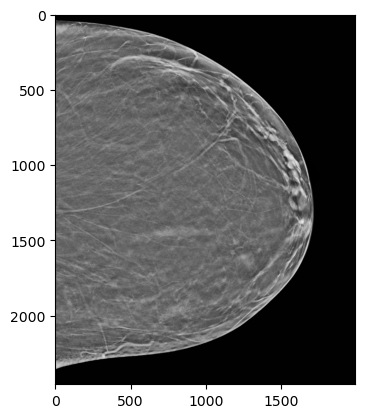

In [89]:
img_pil = Image.open(img)
img_npy = np.array(img_pil)
img_width = img_npy.shape[1]
img_height = img_npy.shape[0]
img_npy0 = np.copy(img_npy)
img_npy1 = np.copy(img_npy)
plt.imshow(img_npy0, cmap='gray')

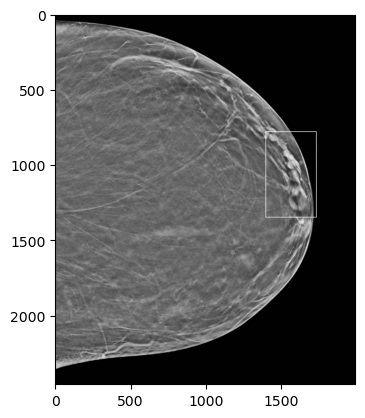

In [67]:
gt_df = pd.read_csv(gt_txt, sep=' ', header=None)

for idx in gt_df.index:
    # scorro su tutte le bbox e prendo i vari valori
    x_center = gt_df.iloc[idx][1]
    y_center = gt_df.iloc[idx][2]
    width = gt_df.iloc[idx][3]
    height = gt_df.iloc[idx][4]

    # modifico l'immagine 'disegnandoci' dentro le bbox
    img_npy_gt = draw_box(img_npy, x_center=x_center, y_center=y_center, 
                width=width, height=height, 
                img_width=img_width, img_height=img_height, color=255)
    
plt.imshow(img_npy_gt, cmap='gray')

In [68]:
gt_list = []

for idx in gt_df.index:
            x_center = gt_df.iloc[idx][1]
            y_center = gt_df.iloc[idx][2]
            width = gt_df.iloc[idx][3]
            height = gt_df.iloc[idx][4]

            gt_element = [x_center, y_center, width, height]
            gt_list.append(gt_element) # è una lista di liste, ciascuna delle quali contiene gli elementi di un bbox


In [69]:
found_masses = np.zeros(shape=len(gt_list))

In [70]:
pred_df = pd.read_csv(pred_txt, sep=' ', header=None)

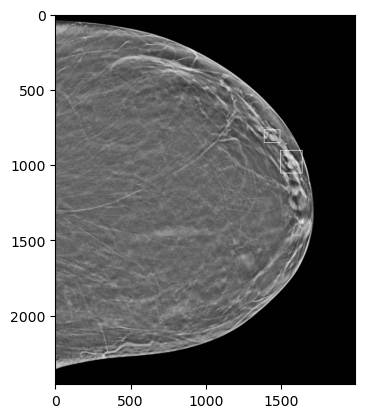

In [71]:
for idx in pred_df.index:
    # scorro su tutte le bbox e prendo i vari valori
    x_center = pred_df.iloc[idx][1]
    y_center = pred_df.iloc[idx][2]
    width = pred_df.iloc[idx][3]
    height = pred_df.iloc[idx][4]

    # modifico l'immagine 'disegnandoci' dentro le bbox
    img_npy_pred = draw_box(img_npy1, x_center=x_center, y_center=y_center, 
                width=width, height=height, 
                img_width=img_width, img_height=img_height, color=255)
    
plt.imshow(img_npy_pred, cmap='gray')
        

In [72]:
pred_list = []

for idx in pred_df.index:
    x_center = pred_df.iloc[idx][1]
    y_center = pred_df.iloc[idx][2]
    width = pred_df.iloc[idx][3]
    height = pred_df.iloc[idx][4]
    confidence = pred_df.iloc[idx][5]

    pred_element = [x_center, y_center, width, height, confidence]
    pred_list.append(pred_element)


In [73]:
gt_list

[[0.7840681362725451,
  0.4334554334554334,
  0.1703406813627254,
  0.2332112332112332]]

In [74]:
pred_list

[[0.720942, 0.330484, 0.0551102, 0.03663, 0.103345],
 [0.785321, 0.399064, 0.0736473, 0.0630851, 0.107638]]

In [79]:
iou_list = []
for detection in pred_list:
    distances = []
    # per ogni elemento trovato, inizializzo una lista, 
    # poi guardo quanto dista da tutti i bbox della gt e appendo alla lista
    for bbox in gt_list:
        pred_xy = np.array(detection[0:2])
        gt_xy = np.array(bbox[0:2])

        distance = linalg.norm(pred_xy - gt_xy)
        distances.append(distance)

    # trovo a quale massa GT sta più vicino e per quella calcolo la IOU
    closest_item = np.argmin(distances)
    gt_values = gt_list[closest_item]
    iou_value = iou(x1=detection[0], y1=detection[1], w1=detection[2], h1=detection[3],
                    x2=gt_values[0], y2=gt_values[1], w2=gt_values[2], h2=gt_values[3])
    
    iou_list.append(iou_value)

    # se la IOU è minore di una certa soglia, le considero come coincidenti
    if iou_value >= iou_threshold:
        # print(f'è un vero Vero Positivo, massa più vicina riga {closest_item}')
        found_masses[closest_item] = 1

In [80]:
iou_list

[0.03945919674714911, 0.11695418851709774]

In [77]:
detection = pred_list[1]
distances = []
# per ogni elemento trovato, inizializzo una lista, 
# poi guardo quanto dista da tutti i bbox della gt e appendo alla lista
for bbox in gt_list:
    pred_xy = np.array(detection[0:2])
    gt_xy = np.array(bbox[0:2])

    distance = linalg.norm(pred_xy - gt_xy)
    distances.append(distance)

# trovo a quale massa GT sta più vicino e per quella calcolo la IOU
closest_item = np.argmin(distances)
gt_values = gt_list[closest_item]
iou_value = iou(x1=detection[0], y1=detection[1], w1=detection[2], h1=detection[3],
                x2=gt_values[0], y2=gt_values[1], w2=gt_values[2], h2=gt_values[3])

# se la IOU è minore di una certa soglia, le considero come coincidenti
if iou_value >= iou_threshold:
    # print(f'è un vero Vero Positivo, massa più vicina riga {closest_item}')
    found_masses[closest_item] = 1

In [78]:
found_masses

array([0.])

## Seconda massa (LMLO)

In [81]:
gt_txt_lmlo = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/labels_gt/DBT-P01839_DBT-S03748_lmlo_mass0_slice12.txt'
pred_txt_lmlo = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/labels_detection/DBT-P01839_DBT-S03748_lmlo_mass0_slice12.txt'
img_lmlo = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/images/DBT-P01839_DBT-S03748_lmlo_mass0_slice12.png'

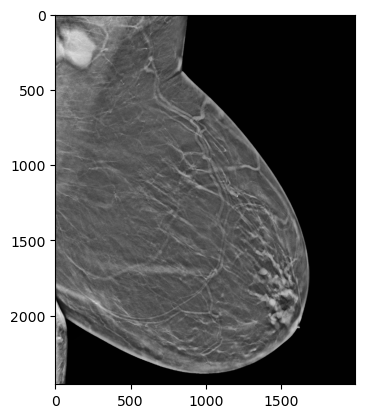

In [98]:
img_pil_lmlo = Image.open(img_lmlo)
img_npy_lmlo = np.array(img_pil_lmlo)
img_width_lmlo = img_npy_lmlo.shape[1]
img_height_lmlo = img_npy_lmlo.shape[0]
img_npy_lmlo0 = np.copy(img_npy_lmlo)
img_npy_lmlo1 = np.copy(img_npy_lmlo)
plt.imshow(img_npy_lmlo, cmap='gray')

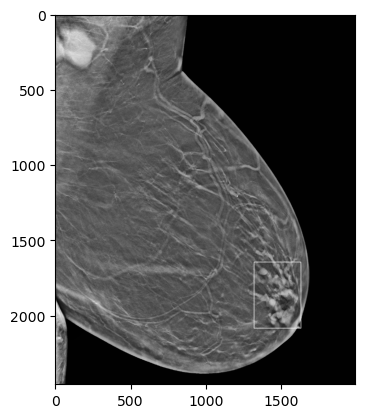

In [99]:
gt_df = pd.read_csv(gt_txt_lmlo, sep=' ', header=None)

for idx in gt_df.index:
    # scorro su tutte le bbox e prendo i vari valori
    x_center = gt_df.iloc[idx][1]
    y_center = gt_df.iloc[idx][2]
    width = gt_df.iloc[idx][3]
    height = gt_df.iloc[idx][4]

    # modifico l'immagine 'disegnandoci' dentro le bbox
    img_npy_lmlo_gt = draw_box(img_npy_lmlo, x_center=x_center, y_center=y_center, 
                width=width, height=height, 
                img_width=img_width_lmlo, img_height=img_height_lmlo, color=255)
    
plt.imshow(img_npy_lmlo_gt, cmap='gray')

In [100]:
gt_list = []

for idx in gt_df.index:
            x_center = gt_df.iloc[idx][1]
            y_center = gt_df.iloc[idx][2]
            width = gt_df.iloc[idx][3]
            height = gt_df.iloc[idx][4]

            gt_element = [x_center, y_center, width, height]
            gt_list.append(gt_element) # è una lista di liste, ciascuna delle quali contiene gli elementi di un bbox


In [101]:
found_masses = np.zeros(shape=len(gt_list))

In [103]:
pred_df = pd.read_csv(pred_txt_lmlo, sep=' ', header=None)

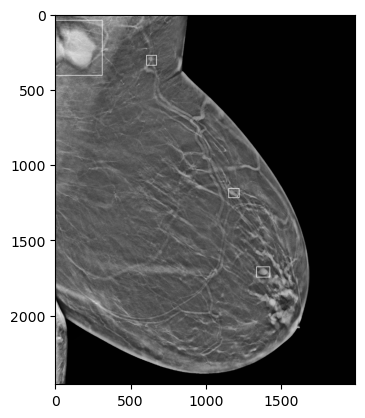

In [104]:
for idx in pred_df.index:
    # scorro su tutte le bbox e prendo i vari valori
    x_center = pred_df.iloc[idx][1]
    y_center = pred_df.iloc[idx][2]
    width = pred_df.iloc[idx][3]
    height = pred_df.iloc[idx][4]

    # modifico l'immagine 'disegnandoci' dentro le bbox
    img_npy_pred_lmlo = draw_box(img_npy_lmlo1, x_center=x_center, y_center=y_center, 
                width=width, height=height, 
                img_width=img_width_lmlo, img_height=img_height_lmlo, color=255)
    
plt.imshow(img_npy_pred_lmlo, cmap='gray')
        

In [105]:
pred_list = []

for idx in pred_df.index:
    x_center = pred_df.iloc[idx][1]
    y_center = pred_df.iloc[idx][2]
    width = pred_df.iloc[idx][3]
    height = pred_df.iloc[idx][4]
    confidence = pred_df.iloc[idx][5]

    pred_element = [x_center, y_center, width, height, confidence]
    pred_list.append(pred_element)


In [106]:
gt_list

[[0.7389779559118237,
  0.7594627594627594,
  0.158316633266533,
  0.1803011803011803]]

In [107]:
pred_list

[[0.594689, 0.484127, 0.0370741, 0.027269, 0.100222],
 [0.320892, 0.125153, 0.0355711, 0.028897, 0.15099],
 [0.691633, 0.697395, 0.0465932, 0.029711, 0.307153],
 [0.0789078, 0.0913716, 0.157816, 0.150997, 0.43693]]

In [110]:
iou_list = []

for detection in pred_list:
    distances = []
    # per ogni elemento trovato, inizializzo una lista, 
    # poi guardo quanto dista da tutti i bbox della gt e appendo alla lista
    for bbox in gt_list:
        pred_xy = np.array(detection[0:2])
        gt_xy = np.array(bbox[0:2])

        distance = linalg.norm(pred_xy - gt_xy)
        distances.append(distance)

    # trovo a quale massa GT sta più vicino e per quella calcolo la IOU
    closest_item = np.argmin(distances)
    gt_values = gt_list[closest_item]
    iou_value = iou(x1=detection[0], y1=detection[1], w1=detection[2], h1=detection[3],
                    x2=gt_values[0], y2=gt_values[1], w2=gt_values[2], h2=gt_values[3])
    iou_list.append(iou_value)

    # se la IOU è minore di una certa soglia, le considero come coincidenti
    if iou_value >= iou_threshold:
        # print(f'è un vero Vero Positivo, massa più vicina riga {closest_item}')
        found_masses[closest_item] = 1

In [111]:
iou_list

[0.0, 0.0, 0.04849697971681878, 0.0]